<a href="https://colab.research.google.com/github/WHG555/GoogleCode/blob/master/first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''-------------------------------1、文件说明--------------------------------'''  
'''
 * 项目说明：RetinaNet模型训练代码  
 * 项目时间：2019-8-30  
 * 项目人员：whg  
'''  

'\n * 项目说明：RetinaNet模型训练代码  \n * 项目时间：2019-8-30  \n * 项目人员：whg  \n'

In [0]:
from torch import nn
 
class simpleNet(nn.Module):
    """
    定义了一个简单的三层全连接神经网络，每一层都是线性的
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(simpleNet, self).__init__()
        self.layer1 = nn.Linear(in_dim, n_hidden_1)
        self.layer2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.layer3 = nn.Linear(n_hidden_2, out_dim)
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
 
class Activation_Net(nn.Module):
    """
    在上面的simpleNet的基础上，在每层的输出部分添加了激活函数
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Activation_Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        """
        这里的Sequential()函数的功能是将网络的层组合到一起。
        """
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
 
class Batch_Net(nn.Module):
    """
    在上面的Activation_Net的基础上，增加了一个加快收敛速度的方法——批标准化
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Batch_Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [0]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
 
# 之前所定义的神经网络模型
# import net

In [0]:
# 定义一些超参数
batch_size = 64
learning_rate = 0.02
num_epoches = 20

In [0]:
# 数据预处理。transforms.ToTensor()将图片转换成PyTorch中处理的对象Tensor,并且进行标准化（数据在0~1之间）
# transforms.Normalize()做归一化。它进行了减均值，再除以标准差。两个参数分别是均值和标准差
# transforms.Compose()函数则是将各种预处理的操作组合到了一起
data_tf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

In [6]:
# 数据集的下载器
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=data_tf, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=data_tf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 19753510.14it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 318060.32it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5278583.67it/s]                           
8192it [00:00, 132671.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [7]:
print(test_loader.dataset.training_file)

training.pt


In [0]:
# 选择模型
model = simpleNet(28 * 28, 300, 100, 10)
# model = net.Activation_Net(28 * 28, 300, 100, 10)
# model = net.Batch_Net(28 * 28, 300, 100, 10)
if torch.cuda.is_available():
    model = model.cuda()
 
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
# 训练模型
epoch = 0
print(train_loader.batch_size)
date = []
ydata = []
for data in train_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    if torch.cuda.is_available():
        img = img.cuda()
        label = label.cuda()
    else:
        img = Variable(img)
        label = Variable(label)
    out = model(img)
    loss = criterion(out, label)
    print_loss = loss.data.item()
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch+=1
    if epoch%50 == 0:
        print('epoch: {}, loss: {:.4}'.format(epoch, loss.data.item()))
        date.append(epoch)
        ydata.append(loss.cpu().data.numpy())

64
epoch: 50, loss: 0.285
epoch: 100, loss: 0.1499
epoch: 150, loss: 0.2028
epoch: 200, loss: 0.4418
epoch: 250, loss: 0.2907
epoch: 300, loss: 0.5267
epoch: 350, loss: 0.2688
epoch: 400, loss: 0.4495
epoch: 450, loss: 0.5282
epoch: 500, loss: 0.263
epoch: 550, loss: 0.6128
epoch: 600, loss: 0.47
epoch: 650, loss: 0.2796
epoch: 700, loss: 0.443
epoch: 750, loss: 0.4387
epoch: 800, loss: 0.3276
epoch: 850, loss: 0.2581
epoch: 900, loss: 0.4652


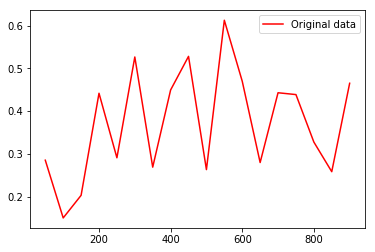

In [23]:
import matplotlib.pyplot as plt
plt.plot(date, ydata, 'r-', label='Original data')
plt.legend()
plt.show()

# 新段落

# 新段落

In [10]:
()# 模型评估
model.eval()
eval_loss = 0
eval_acc = 0
for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    if torch.cuda.is_available():
        img = img.cuda()
        label = label.cuda()
 
    out = model(img)
    loss = criterion(out, label)
    eval_loss += loss.data.item()*label.size(0)
    _, pred = torch.max(out, 1)
    num_correct = (pred == label).sum()
    eval_acc += num_correct.item()
print('Test Loss: {:.6f}, Acc: {:.6f}'.format(
    eval_loss / (len(test_dataset)),
    eval_acc / (len(test_dataset))
))

Test Loss: 0.334727, Acc: 0.899400


In [0]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot